### Predict house price based on defined features (ML Model)
### London house price dataset

In [23]:
import os
import math
import random

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [24]:
# 1. Load UK Land Registry data
# source: https://www.kaggle.com/datasets/jakewright/house-price-data
csv_path = 'data/kaggle_london_house_price_data.csv'
df =pd.read_csv(csv_path)

print('shape:', df.shape)
df.head()

shape: (418201, 28)


,fullAddress,postcode,country,outcode,latitude,longitude,bathrooms,bedrooms,floorAreaSqM,livingRooms,...,saleEstimate_upperPrice,saleEstimate_confidenceLevel,saleEstimate_ingestedAt,saleEstimate_valueChange.numericChange,saleEstimate_valueChange.percentageChange,saleEstimate_valueChange.saleDate,history_date,history_price,history_percentageChange,history_numericChange
0,"Flat 9, 35 Furnival Street, London, EC4A 1JQ",EC4A 1JQ,England,EC4A,51.517282,-0.110314,1.0,1.0,45.0,1.0,...,630000.0,HIGH,2024-10-07T13:26:59.894Z,244000.0,68.539326,2010-03-30,1995-01-02,830000,NaN,NaN
1,"Flat 6, 35 Furnival Street, London, EC4A 1JQ",EC4A 1JQ,England,EC4A,51.517282,-0.110314,NaN,NaN,NaN,NaN,...,660000.0,MEDIUM,2024-10-07T13:26:59.894Z,425000.0,242.857143,2000-05-26,1995-01-02,830000,NaN,NaN
2,"Flat 35, Octavia House, Medway Street, London,...",SW1P 2TA,England,SW1P,51.495505,-0.132379,2.0,2.0,71.0,1.0,...,834000.0,MEDIUM,2025-01-10T11:04:57.114Z,49000.0,6.901408,2019-09-04,1995-01-03,249950,NaN,NaN
3,"24 Chester Court, Lomond Grove, London, SE5 7HS",SE5 7HS,England,SE5,51.478185,-0.092201,1.0,1.0,64.0,1.0,...,407000.0,HIGH,2024-10-07T13:26:59.894Z,28000.0,7.777778,2024-01-25,1995-01-03,32000,NaN,NaN
4,"18 Alexandra Gardens, London, N10 3RL",N10 3RL,England,N10,51.588774,-0.139599,1.0,4.0,137.0,2.0,...,1324000.0,HIGH,2024-10-07T13:26:59.894Z,81000.0,6.864407,2022-12-14,1995-01-03,133000,NaN,NaN


### Explore data and clean

In [25]:
print(df.describe())
print(df.columns)

            latitude      longitude      bathrooms       bedrooms  \
count  418201.000000  418201.000000  340270.000000  377665.000000   
mean       51.507522      -0.101426       1.444265       2.474884   
std         0.056171       0.086930       0.724478       1.160506   
min        51.385708      -0.347055       1.000000       1.000000   
25%        51.464315      -0.155996       1.000000       2.000000   
50%        51.501581      -0.108482       1.000000       2.000000   
75%        51.548515      -0.043582       2.000000       3.000000   
max        51.665823       0.139249       9.000000       9.000000   

        floorAreaSqM    livingRooms  rentEstimate_lowerPrice  \
count  392991.000000  357701.000000            416460.000000   
mean       98.926543       1.282275              3299.054171   
std        55.938911       0.574412              3168.625404   
min        10.000000       1.000000               300.000000   
25%        63.000000       1.000000              1800.0000

In [26]:
# notes on features:
# df.propertyType
# property type is an important categorical feature, but need to convert to correct type first
# rooms = bedrooms + livingrooms
# it makes mmore sense to combine these two features into one 'rooms' feature

In [27]:
### convert to correct types
df['history_date'] = pd.to_datetime(df['history_date'])
df['history_price'] = df['history_price'].astype(float)

# remove 'bad' data
df = df.dropna(subset=['history_price','history_date'])
df = df.sort_values(by=['history_date'])
print('shape after basic cleaning:', df.shape)

shape after basic cleaning: (418201, 28)


In [28]:
# filter out outliers, 2_000_000 GBP seems reasonable for London housing market
min_price= 50_000
max_price = 2_000_000

df = df[df['history_price'] <= max_price]
df = df[df['history_price'] >= min_price]

print('shape after filtering for outliers:', df.shape)

shape after filtering for outliers: (395361, 28)


In [29]:

cols = [
    'history_date', 
    'history_price', 
    'bedrooms', 
    'livingRooms', 
    'bathrooms', 
    'floorAreaSqM', 
    'latitude', 
    'longitude',
    'propertyType'
    ]

df_model= df[cols].copy()
# drop rows with missing values in any of the selected columns
df_model= df_model.dropna(subset=["history_date","history_price","floorAreaSqM"])

# convert numerical columns to numeric types
num_cols=["bedrooms", "livingRooms", "bathrooms", "floorAreaSqM", "latitude", "longitude"]
for col in num_cols:
    df_model[col] = pd.to_numeric(df_model[col], errors='coerce')

df_model= df_model.dropna(subset=num_cols).reset_index(drop=True)

# sorting by date
df_model = df_model.sort_values(by='history_date').reset_index(drop=True)

print('shape after cleaning:', df.shape)

shape after cleaning: (395361, 28)


In [30]:
# feature engineering
# create log price feature
df_model['log_price'] = np.log(df_model['history_price'])

# engineer rooms feature
# rooms = bedrooms + livingRooms
df_model['rooms'] = df_model['bedrooms'].fillna(0) + df_model['livingRooms'].fillna(0)

df_model['propertyType'] = df_model['propertyType'].astype('category')
df_model['propertyype_cat'] = df_model['propertyType'].cat.codes
ptype_dummies = pd.get_dummies(df_model['propertyype_cat'], prefix='ptype')

df_model = pd.concat([df_model, ptype_dummies], axis=1)

df_model.head()

,history_date,history_price,bedrooms,livingRooms,bathrooms,floorAreaSqM,latitude,longitude,propertyType,log_price,...,ptype_9,ptype_10,ptype_11,ptype_12,ptype_13,ptype_14,ptype_15,ptype_16,ptype_17,ptype_18
0,1995-01-02,830000.0,1.0,1.0,1.0,45.0,51.517282,-0.110314,Purpose Built Flat,13.629181,...,False,False,False,True,False,False,False,False,False,False
1,1995-01-03,249950.0,2.0,1.0,2.0,71.0,51.495505,-0.132379,Flat/Maisonette,12.429016,...,False,False,False,False,False,False,False,False,False,False
2,1995-01-03,133000.0,4.0,2.0,1.0,137.0,51.588774,-0.139599,End Terrace House,11.798104,...,False,False,False,False,False,False,False,False,False,False
3,1995-01-03,128500.0,2.0,1.0,1.0,97.0,51.466089,0.006967,Mid Terrace House,11.763684,...,False,True,False,False,False,False,False,False,False,False
4,1995-01-03,75000.0,3.0,2.0,1.0,135.0,51.451327,-0.007569,Terrace Property,11.225243,...,False,False,False,False,False,False,False,True,False,False


In [31]:
feature_cols = [
    'rooms',
    'bathrooms',
    'floorAreaSqM',
    'latitude',
    'longitude'
] + list(ptype_dummies.columns)

# drop rows with missing values in feature columns or target
df_model = df_model.dropna(subset=feature_cols + ['log_price'])

X = df_model[feature_cols].values
y = df_model['log_price'].values.reshape(-1, 1)

print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (304040, 24)
y shape: (304040, 1)


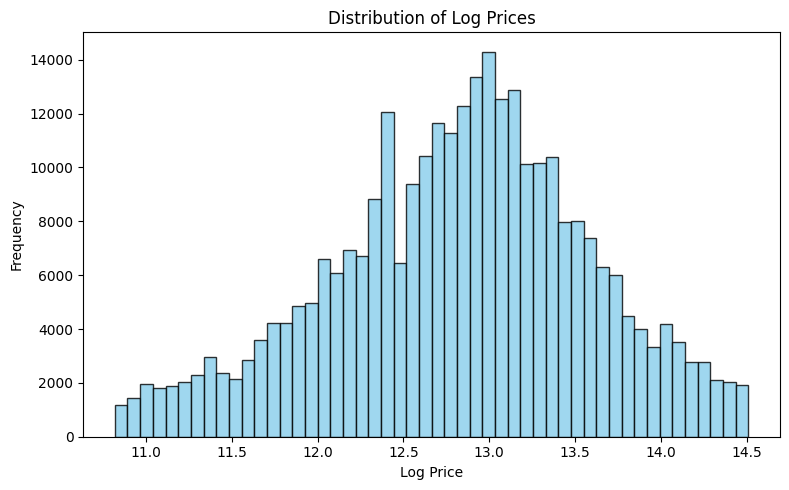

In [32]:
# visualize log price distribution
plt.figure(figsize=(8,5))
plt.hist(df_model['log_price'], bins=50,alpha=0.8, color='skyblue', edgecolor='black')
plt.xlabel('Log Price')
plt.ylabel('Frequency')
plt.title('Distribution of Log Prices')
plt.tight_layout()
plt.show()


### Training split